<h1>Estudo da Covid-19 no Brasil</h1>
<b>Éverton Bin</b><br>
<b>Junho, 2020</b>

<h2>Índice</h2>
<ol>
    <a href = '#intro'><li><b>Introdução</b></li></a>
    <a href = '#carrega'><li><b>Carregando os Dados</b></li></a>
    <a href = '#analise'><li><b>Análise Exploratória</b></li></a>
    <a href = '#modelo'><li><b>Criação dos Modelos Preditivos</b></a>
        <ol>
            <a href = '#modelosp'><li><b>Modelos de Regressão: São Paulo - SP</b></li></a>
            <a href = '#modelorj'><li><b>Modelos de Regressão: Rio de Janeiro - RJ</b></li></a>
            <a href = '#modelobl'><li><b>Modelos de Regressão: Belém - PA</b></li></a>
            <a href = '#modelopa'><li><b>Modelos de Regressão: Porto Alegre - RS</b></li></a>
        </ol>
    <a href = '#prev'><li><b>Previsões</b></li></a>
        <ol>
            <a href = '#prevsp'><li><b>Prevendo as Mortes em São Paulo - SP</b></li></a>
            <a href = '#prevrj'><li><b>Prevendo as Mortes no Rio de Janeiro - RJ</b></li></a>
            <a href = '#prevbl'><li><b>Prevendo as Mortes em Belém - PA</b></li></a>
            <a href = '#prevpa'><li><b>Prevendo as Mortes em Porto Alegre - RS</b></li></a>
        </ol>
    <a href = '#conclusao'><li><b>Conclusão</b></li></a>
</ol>

<h2 id = intro>1- Introdução</h2>

<p>
    Este projeto tem como objetivo fazer uma análise dos dados sobre a pandemia da Covid-19 no Brasil, sobretudo em algumas cidades brasileiras de interesse. Os dados utilizados neste notebook são disponibilizados no Kaggle e podem ser acessados no seguinte link: <a href = "https://www.kaggle.com/unanimad/corona-virus-brazil/data?select=brazil_population_2019.csv"> Coronavirus - Brazil </a>. Após esta breve análise, o objetivo é construir um modelo de regressão capaz de prever o número de mortes causadas pelo vírus em datas futuras.
</p>
<p>
    O arquivo de referência para este estudo, "brazil_covid19_cities.csv", apresenta os seguintes dados sobre a pandemia no país:
    <li><i>date</i>: data de confirmação dos casos;</li>
    <li><i>state</i>: estado brasileiro de referência dos casos;</li>
    <li><i>name</i>: nome da cidade de referência dos casos;</li>
    <li><i>code</i>: código da cidade;</li>
    <li><i>cases</i>: número de casos confirmados;</li>
    <li><i>deaths</i>: número de mortes confirmadas pelo Covid19.</li>
</p>
<p>
    Este dataset será analisado juntamente com o dataset "brazil_population_2019.csv", também disponibilizado na página indicada anteriormente, para que se possa avaliar a situação dos casos proporcionalmente à população da cidade de referência.</p>

<h2 id = carrega>2- Carregando os Dados</h2>

In [1]:
# Pacotes utilizados:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

In [2]:
# Leitura dos arquivos:
covid_br = pd.read_csv('brazil_covid19_cities.csv', parse_dates = ['date'])
cities_pop = pd.read_csv('brazil_population_2019.csv')

In [3]:
# Verificando o formato das variáveis:
covid_br.dtypes

date      datetime64[ns]
state             object
name              object
code               int64
cases              int64
deaths             int64
dtype: object

In [4]:
# Observando as primeiras linhas dos datasets:
covid_br.head()

,date,state,name,code,cases,deaths
0,2020-03-28,Acre,Rio Branco,120040,25,0
1,2020-03-28,Alagoas,Maceió,270430,13,0
2,2020-03-28,Alagoas,Porto Real do Colégio,270750,1,0
3,2020-03-28,Amapá,Macapá,160030,4,0
4,2020-03-28,Amazonas,Boca do Acre,130070,1,0


In [5]:
# Alterando a nomeclatura de cada estado para o seu respectivo 'UF':
estado_uf = {'Acre': 'AC', 'Alagoas': 'AL', 'Amapá': 'AP', 'Amazonas': 'AM', 'Bahia': 'BA', 'Ceará': 'CE',
              'Distrito Federal': 'DF', 'Espírito Santo': 'ES', 'Goiás': 'GO', 'Maranhão': 'MA', 'Minas Gerais': 'MG',
              'Mato Grosso do Sul': 'MS', 'Mato Grosso': 'MT', 'Pará': 'PA', 'Paraíba': 'PB', 'Pernambuco': 'PE',
              'Piauí': 'PI', 'Paraná': 'PR', 'Rio de Janeiro': 'RJ', 'Rio Grande do Norte': 'RN', 'Rondônia': 'RO',
              'Roraima': 'RR', 'Rio Grande do Sul': 'RS', 'Santa Catarina': 'SC', 'Sergipe': 'SE', 'São Paulo': 'SP',
              'Tocantins': 'TO'}

covid_br = covid_br.replace({'state': estado_uf})

# Criando a variável 'city', concatenando a cidade e o 'UF' do seu respectivo estado de referência:
covid_br['city'] = covid_br['name'] + ' - ' + covid_br['state']

# Selecionando apenas as capitais de cada estado:
capitais = ['Aracaju - SE', 'Belém - PA', 'Belo Horizonte - MG', 'Boa Vista - RR', 'Brasília - DF', 'Campo Grande - MS',
            'Cuiabá - MT', 'Curitiba - PR', 'Florianópolis - SC', 'Fortaleza - CE', 'Goiânia - GO', 'João Pessoa - PB',
            'Macapá - AP', 'Maceió - AL', 'Manaus - AM', 'Natal - RN', 'Palmas - TO', 'Porto Alegre - RS',
            'Porto Velho - RO', 'Recife - PE', 'Rio Branco - AC', 'Rio de Janeiro - RJ', 'Salvador - BA', 'São Luís - MA',
            'São Paulo - SP', 'Teresina - PI', 'Vitória - ES']

covid_cap_br = covid_br[covid_br.city.isin(capitais)]

# Deletando as colunas 'state' e 'name' do dataset:
covid_cap_br = covid_cap_br.drop(columns = ['state', 'name'])

covid_cap_br.head()

,date,code,cases,deaths,city
0,2020-03-28,120040,25,0,Rio Branco - AC
1,2020-03-28,270430,13,0,Maceió - AL
3,2020-03-28,160030,4,0,Macapá - AP
6,2020-03-28,130260,105,0,Manaus - AM
24,2020-03-28,292740,82,0,Salvador - BA


In [6]:
# Incorporando o número populacional ao dataset com informações sobre a Covid-19:
covid_cap_br = covid_cap_br.rename(columns = {'code' : 'city_code'})
cities_pop = cities_pop[['city_code', 'population']]
covid_cap_br = pd.merge(covid_cap_br, cities_pop, on = 'city_code')
covid_cap_br.head()

,date,city_code,cases,deaths,city,population
0,2020-03-28,120040,25,0,Rio Branco - AC,407319
1,2020-03-29,120040,31,0,Rio Branco - AC,407319
2,2020-03-30,120040,35,0,Rio Branco - AC,407319
3,2020-03-31,120040,34,0,Rio Branco - AC,407319
4,2020-04-01,120040,34,0,Rio Branco - AC,407319


<h2 id = analise>3- Análise Exploratória</h2>

<p>
    Serão criadas novas colunas para representar o número de casos e mortes por 100 mil habitantes para que, posteriormente, as comparações possam ser feitas de maneira proporcional.
</p>

In [7]:
covid_atual = covid_cap_br[covid_cap_br['date'] == max(covid_cap_br['date'])]

covid_atual['cases_rate'] = round(((covid_atual['cases'] / covid_atual['population'])*100000), 1)

covid_atual['deaths_rate'] = round(((covid_atual['deaths'] / covid_atual['population'])*100000), 1)

covid_atual['deaths_prop'] = round(((covid_atual['deaths'] / covid_atual['cases'])*100), 1)

covid_atual.head()

,date,city_code,cases,deaths,city,population,cases_rate,deaths_rate,deaths_prop
73,2020-06-09,120040,4703,160,Rio Branco - AC,407319,1154.6,39.3,3.4
147,2020-06-09,270430,8698,406,Maceió - AL,1018948,853.6,39.8,4.7
221,2020-06-09,160030,5750,170,Macapá - AP,503327,1142.4,33.8,3.0
295,2020-06-09,130260,21605,1501,Manaus - AM,2182763,989.8,68.8,6.9
369,2020-06-09,292740,17224,640,Salvador - BA,2872347,599.6,22.3,3.7


In [8]:
# Criando uma função genérica para dispor os valores nas barras do gráfico:
def show_values_on_bars(axs, max_value):
    def _show_on_single_plot(ax):
        for b in ax.patches:
            _x = b.get_x() + b.get_width() / 2
            _y = b.get_y() + b.get_height() - (0.05*max_value)
            value = '{:.1f}'.format(b.get_height())
            ax.text(_x, _y, value, ha="center", color = 'k', fontsize = 11) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Criando uma função genérica para dispor as percentagens nas barras do gráfico:
def show_percentage_on_bars(axs, max_value):
    def _show_on_single_plot(ax):
        for b in ax.patches:
            _x = b.get_x() + b.get_width() / 2
            _y = b.get_y() + b.get_height() - (0.05*max_value)
            value = '{:.1f}'.format(b.get_height())+'%'
            ax.text(_x, _y, value, ha="center", color = 'k', fontsize = 11) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

<Figure size 432x288 with 0 Axes>

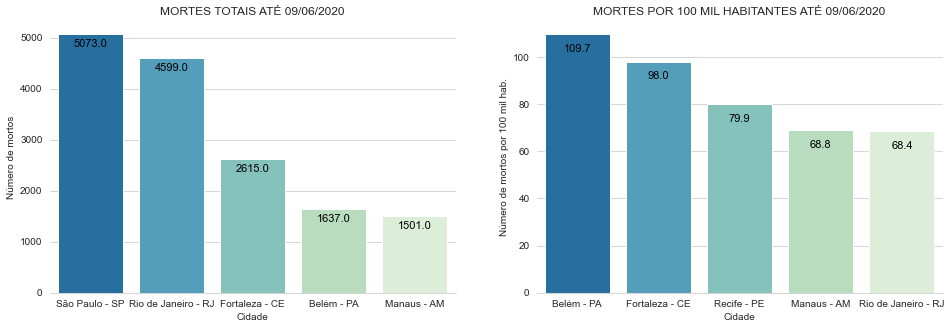

In [9]:
# Ordenando o dataset por número de mortes:
covid_deaths = covid_atual.sort_values(by = ['deaths'], ascending = False)

# Ordenando o dataset por número de mortes por 100 mil habitantes:
covid_deaths_rate = covid_atual.sort_values(by = ['deaths_rate'], ascending = False)

# Ordenando o dataset por número de casos confirmados por 100 mil habitantes:
covid_cases_rate = covid_atual.sort_values(by = ['cases_rate'], ascending = False)

# Criando variáveis que indicam a primeira e última datas apresentadas no dataset:
ult_date = max(covid_cap_br['date']).strftime('%d/%m/%Y')
min_date = min(covid_cap_br['date']).strftime('%d/%m/%Y')

# Criando o plot:
sns.set_style("whitegrid")
sns.despine(left=True)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

sns.set_style("whitegrid")
sns.despine(left=True)

bars0 = sns.barplot(x = 'city', y = 'deaths', data = covid_deaths[0:5], ci = None,
            palette = 'GnBu_r', ax = ax[0]).set_title('MORTES TOTAIS ATÉ '+ ult_date)
ax[0].set_xlabel('Cidade')
ax[0].set_ylabel('Número de mortos')

show_values_on_bars(ax[0],5000)

bars1 = sns.barplot(x = 'city', y = 'deaths_rate', data = covid_deaths_rate[0:5], ci = None,
            palette = 'GnBu_r', ax = ax[1]).set_title('MORTES POR 100 MIL HABITANTES ATÉ '+ ult_date)
ax[1].set_xlabel('Cidade')
ax[1].set_ylabel('Número de mortos por 100 mil hab.')

show_values_on_bars(ax[1],150)

fig.show()

<p>
    É possível observar que, se for considerado unicamente o número de mortos, as cidades de <b>São Paulo</b> e <b>Rio de Janeiro</b> são os destaques negativos no país, sendo responsáveis pelo maior número de mortes entre as capitais brasileiras.
</p>
<p>
    No entanto, se considerarmos o número de mortes pela Covid-19 relativamente à população total de cada uma das cidades, São Paulo e Rio de Janeiro dão lugar às cidades de <b>Belém</b> e <b>Fortaleza</b> como sendo as capitais com mais mortes por 100 mil habitantes no Brasil, sendo que <b>Belém</b> passou da casa de 100 mortes por 100 mil habitantes, enquanto <b>Fortaleza</b> se aproxima muito desta mesma marca.
</p>

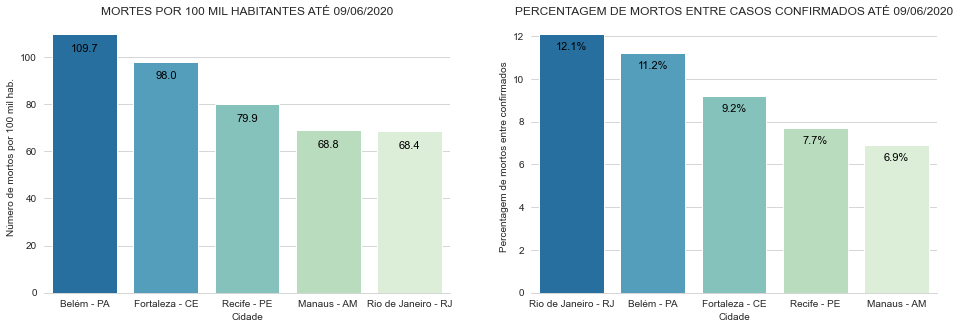

In [10]:
# Ordenando o dataset por percentagem de mortos entre os casos confirmados:
covid_deaths_prop = covid_atual.sort_values(by = ['deaths_prop'], ascending = False)

# Criando o plot:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

sns.set_style("whitegrid")
sns.despine(left=True)

sns.barplot(x = 'city', y = 'deaths_rate', data = covid_deaths_rate[0:5], ci = None,
            palette = 'GnBu_r', ax = ax[0]).set_title('MORTES POR 100 MIL HABITANTES ATÉ '+ ult_date)
ax[0].set_xlabel('Cidade')
ax[0].set_ylabel('Número de mortos por 100 mil hab.')

show_values_on_bars(ax[0],150)

sns.barplot(x = 'city', y = 'deaths_prop', data = covid_deaths_prop[0:5], ci = None,
            palette = 'GnBu_r', ax = ax[1]).set_title('PERCENTAGEM DE MORTOS ENTRE CASOS CONFIRMADOS ATÉ '+ ult_date)
ax[1].set_xlabel('Cidade')
ax[1].set_ylabel('Percentagem de mortos entre confirmados')

show_percentage_on_bars(ax[1],15)

fig.show()

<p>
    Observando os gráficos comparativos acima, pode-se perceber que outros fatores, além da proporção de mortes relativa ao tamanho da população, parecem afetar a percentagem de mortos entre os casos confirmados. Embora <b>Belém</b> seja a capital com a maior proporção de mortos para 100 mil habitantes, é o <b>Rio de Janeiro</b> que apresenta a maior proporção de mortes entre os casos confirmados, número este ao redor dos 12%. <b>Belém</b> apresenta número próximo ao número apresentado pelo Rio de Janeiro, porém levemente menor.
</p>
<p>
    Vamos avaliar também quais são as capitais que se destacam positivamente no país, utilizando como ponto de vista o número total de mortes, o número de mortes por 100 mil habitantes e também a percentagem de mortos entre os casos confirmados:
</p>

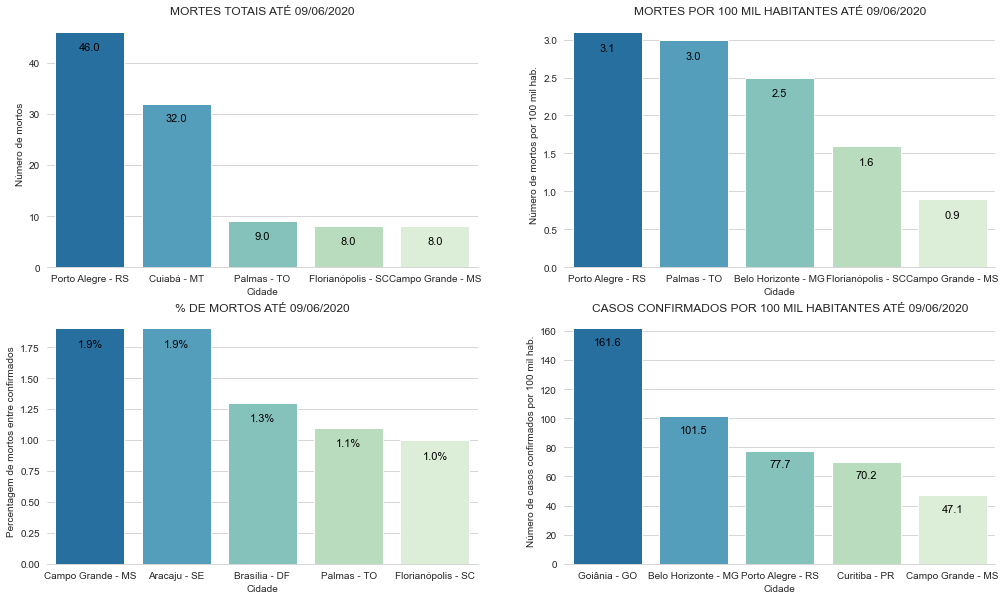

In [11]:
# Criando o plot:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (17, 10))

sns.set_style("whitegrid")
sns.despine(left=True)

sns.barplot(x = 'city', y = 'deaths', data = covid_deaths[22:], ci = None,
            palette = 'GnBu_r', ax = ax[0,0]).set_title('MORTES TOTAIS ATÉ '+ ult_date)
ax[0,0].set_xlabel('Cidade')
ax[0,0].set_ylabel('Número de mortos')

show_values_on_bars(ax[0,0],70)

sns.barplot(x = 'city', y = 'deaths_rate', data = covid_deaths_rate[22:], ci = None,
            palette = 'GnBu_r', ax = ax[0,1]).set_title('MORTES POR 100 MIL HABITANTES ATÉ '+ ult_date)
ax[0,1].set_xlabel('Cidade')
ax[0,1].set_ylabel('Número de mortos por 100 mil hab.')

show_values_on_bars(ax[0,1],5)

sns.barplot(x = 'city', y = 'deaths_prop', data = covid_deaths_prop[22:], ci = None,
            palette = 'GnBu_r', ax = ax[1,0]).set_title('% DE MORTOS ATÉ '+ ult_date)
ax[1,0].set_xlabel('Cidade')
ax[1,0].set_ylabel('Percentagem de mortos entre confirmados')

show_percentage_on_bars(ax[1,0],3)

sns.barplot(x = 'city', y = 'cases_rate', data = covid_cases_rate[22:], ci = None,
            palette = 'GnBu_r', ax = ax[1,1]).set_title('CASOS CONFIRMADOS POR 100 MIL HABITANTES ATÉ '+ ult_date)
ax[1,1].set_xlabel('Cidade')
ax[1,1].set_ylabel('Número de casos confirmados por 100 mil hab.')

show_values_on_bars(ax[1,1],230)

fig.show()

<p>
    <b>Porto Alegre</b> está entre as 5 capitais com o menor número absoluto de mortes e também entre as 5 capitais com o menor número de casos confirmados e moretes por 100 mil habitantes. Ainda assim, não está entre as 5 capitais com a menor percentagem de mortos entre os casos confirmados. Os fatos que justificam esta observação devem ser estudados, no entanto, umas das possíveis razões pode ser o fato de que o Rio Grande do Sul possui uma proporção maior de idosos se comparado aos demais estados do país, sendo a população idosa considerada como um dos grupos com maior risco de desenvolver complicações relacionadas ao vírus.
</p>
<p>
    Já as capitais <b>Campo Grande</b> e <b>Palmas</b>, do ponto de vista analisado, parecem estar em uma situação mais confortável em relação às demais capitais do país. No entanto, é necessário frisar que os casos confirmados são diretamente proporcionais à capacidade e à aplicação da testagem na população, sendo que baixos números de contágio não necessariamente representam baixa evolução da doença na população.
</p>

<p>
    Vamos avaliar também a evolução diária de mortes, principalmente nas capitais que se destacaram até o momento nas análises desenvolvidas. Para tal, será criada uma variável que representa a contagem de dias a partir do primeiro registro apresentado no conjunto de dados. Além disso, será criada uma função para facilitar a criação de um gráfico que represente esta evolução diária de mortes, permitindo uma análise visual da tendência apresentada em cada cidade.
</p>

In [12]:
# Criando uma variável numérica que represente a contagem dos dias a partir da primeira data de referência do dataset:
covid_cap_br['day_count'] = (covid_cap_br['date'] - min(covid_cap_br['date']))
covid_cap_br['day_count'] = pd.to_numeric(covid_cap_br['day_count'].dt.days, downcast='integer')

In [13]:
# Criando uma função que gera um plot que apresenta a evolução do número de mortes dia a dia:
def deaths_per_day(city_name):
    """Cria um gráfico apresentando as mortes dia a dia.
    
    Args:
    city_name: string indicando a cidade a ser filtrada. A convenção no dataset é 'Cidade - UF'.
    """
    filt_city = covid_cap_br[covid_cap_br['city'] == city_name]
    
    filt_city = filt_city.reset_index(drop = True)
    
    filt_city['deaths_per_day'] = ''
    for i in range(0, len(filt_city.index)):
        if i == 0:
            filt_city['deaths_per_day'][i] = filt_city['deaths'][i]
        else:
            if (filt_city['deaths'][(i-1)]) <= (filt_city['deaths'][i]):
                filt_city['deaths_per_day'][i] = filt_city['deaths'][i] - filt_city['deaths'][(i-1)]
            else:
                filt_city['deaths_per_day'][i] = 0
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 5))
    
    sns.set_style("whitegrid")
    sns.despine(left=True)
    
    sns.barplot(x = 'day_count', y = 'deaths_per_day', data = filt_city, palette = "autumn_r").set(
        xlabel = 'Contagem dos dias desde ' + min_date,
        ylabel = 'Mortes diárias',
        title = 'Evolução diária do número de mortes em ' + city_name)
    fig.show()

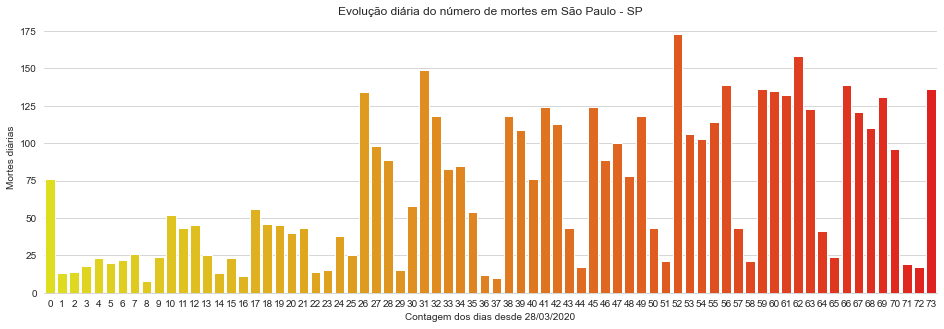

In [14]:
deaths_per_day('São Paulo - SP')

<p>
    Na cidade de <b>São Paulo</b> é possível perceber um padrão no qual os casos de morte reportados diminuem próximo aos finais de semana e aumentam ao longo da semana. É claro também que, após um período de certa estabilidade, os picos de morte apresentam uma tendência de alta.
</p>

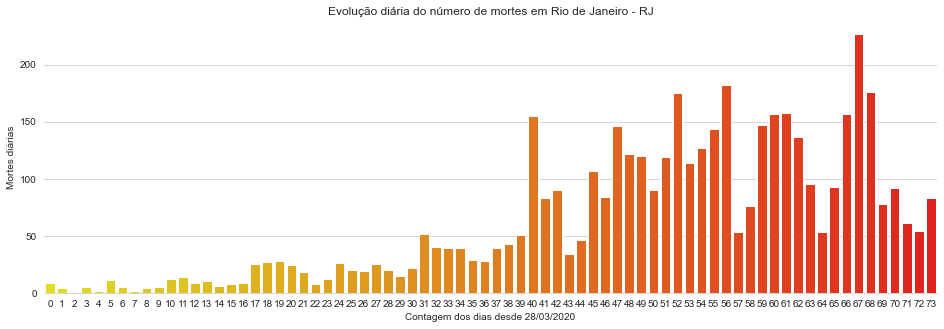

In [15]:
deaths_per_day('Rio de Janeiro - RJ')

<p>
    Parece haver uma tendência de alta no número de mortes na cidade do <b>Rio de Janeiro</b>, tendência esta ainda mais consistente que a apresentada na cidade de São Paulo, onde o aumento de mortes evolui a um passo mais suave. Aparentemente, o segundo mês registrado no dataset representa um aumento sólido no número de mortes no Rio de Janeiro.
</p>

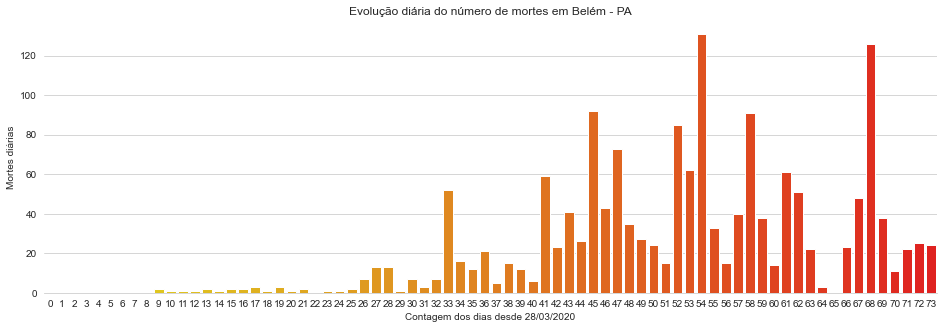

In [16]:
deaths_per_day('Belém - PA')

<p>
    Em <b>Belém</b>, é possível observar picos maiores ao longo das últimas semanas, indicando que a situação local ainda está piorando.
</p>

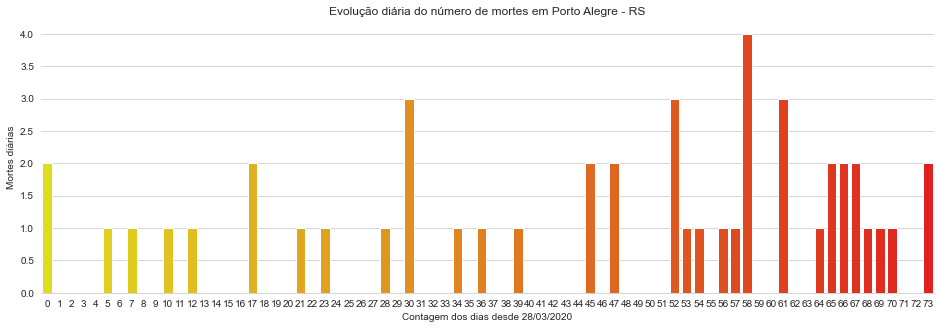

In [17]:
deaths_per_day('Porto Alegre - RS')

<p>
    Como visto anteriormente, <b>Porto Alegre</b> está em uma situação melhor se comparada a outras capitais no país. Ainda assim, o espaçamento de dias sem mortes reportadas diminuiu nos últimos dias, enquanto os picos de mortes apresentam uma tendência de alta.
</p>

<h2 id = modelo>4- Criação de modelo de previsão do número de mortes pelo Covid-19</h2>

<p>
    Para a criação deste modelo preditivo, tentaremos prever o número de mortes unicamente pela data, ou seja, esta será a única variável preditora, já que serão criados modelos separados para algumas capitais de interesse. Sendo assim, a variável alvo, cujo valor queremos prever, é o número de mortes total até a data solicitada.
</p>
<p>
    80% do dataset será utilizado para treinar o modelo e os 20% restantes serão utilizados para avaliar a sua performance na previsão do número correto de mortes, dada uma métrica de comparação.
</p>

<p>
    Na seqüência, serão criadas funções para facilitar o desenvolvimento dos modelos para as diferentes cidades de interesse:
</p>

In [18]:
# Criando função para filtrar cidade e colunas desejadas:
def city_filter(city_name):
    """Filtra o dataset já alterado - neste ponto, covid_cap_br - para a capital de interesse.
    
    Args:
    city_name: string indicando a cidade a ser filtrada. A convenção no dataset é 'Cidade - UF'.
    
    Returns:
    filt_data: dataset contendo os dados referentes à cidade de interesse.
    """
    filt_data = covid_cap_br[covid_cap_br['city'] == city_name]
    filt_data = filt_data[['day_count', 'deaths']]
    return filt_data

# Criando função para plotar gráfico com a evolução do número acumulado de mortes semana a semana:
def deaths_evolution(city_data, city_name):
    """Cria um gráfico de barras com a contagem acumulada das mortes, espaçadas de 7 em 7 dias.
    
    Args:
    city_data: dataset filtrado pela função city_filter();
    city_name: string com o nome da cidade a ser apresentado no gráfico.
    """
    sns.barplot(x = 'day_count', y = 'deaths', data = city_data[city_data['day_count'] % 7 == 0], palette = "Wistia").set(
        xlabel = 'Contagem de dias a partir de ' + min_date,
        ylabel = 'Número de mortes',
        title = 'Evolução do número de mortes na cidade de ' + city_name)
    sns.set_style("whitegrid")
    sns.despine(left=True)

In [19]:
# Criando função para desenvolver, treinar e avaliar o modelo:
def covid_poly_model(city_data, n_degree, seed):
    """Transforma os dados para uma regressão polinomial, cria o modelo de regressão linear e o avalia, juntamente com a
    apresentação de um gráfico que ilustra os dados previstos pelo modelo em relação aos dados originais.
    
    Args:
    city_data: dataset filtrado pela função city_filter();
    n_degree: número que representa o grau da transformação linear a ser aplicada;
    seed: número que permite a reprodução da separação dos dados de treino e de teste para posterior comparação.
    
    Returns:
    poly_regr: modelo de transformação polinomial a ser aplicado posteriormente, permitindo ao modelo fazer previsões;
    model: modelo de regressão linear para fazer as previsões.
    """
    # Separando as variáveis:
    X = city_data[['day_count']]
    Y = city_data[['deaths']]
    
    # Separando os dados em dados de treino e teste por data:
    limit_index = int(0.8*len(X.index))
    X_train = X.iloc[0:limit_index]
    X_test = X.iloc[limit_index:]
    
    Y_train = Y.iloc[0:limit_index]
    Y_test = Y.iloc[limit_index:]
    
    # Aplicando a transformação polinomial aos dados:
    poly_regr = PolynomialFeatures(degree = n_degree)
    X_poly_train = poly_regr.fit_transform(X_train)
    X_poly_test = poly_regr.transform(X_test)
    X_poly = poly_regr.transform(X)
    
    # Criando o modelo:
    model = Ridge(alpha = 15)
    
    # Treinando o modelo:
    model.fit(X_poly_train, Y_train)
    
    # Fazendo as previsões para os dados de teste:
    Y_pred = model.predict(X_poly_test)
    
    # Avaliando o modelo pela métrica MAE (mean absolut error):
    mae = round(mean_absolute_error(Y_test, Y_pred))
    
    sns.scatterplot(x = 'day_count', y = 'deaths', data = city_data).set(
        xlabel = 'Contagem dos dias a partir de ' + min_date,
        ylabel = 'Número de mortos',
        title = 'Evolução Mortes x Regressão Polinomial de Grau ' + str(n_degree))
    plt.plot(X, model.predict(X_poly), color = 'r')
    plt.show()
    
    print('O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau ' +
          str(n_degree) + ' é de: ' + str(mae) + '.')
 
    return poly_regr, model

<p>
    Abaixo, vamos criar um modelo de regressão para a cidade de <b>São Paulo</b>. O algoritmo utilizado será o <b>LinearRegression</b> juntamente com o algoritmo <b>PolynomialFeatures</b>, ambos do pacote Scikit-Learn - como pode ser observado na função criada anteriormente.
</p>
<p>
    Esta mesma função será aplicada para criar os modelos de previsão para as demais capitais de interesse.
</p>

<h3 id = modelosp>São Paulo - SP</h3>

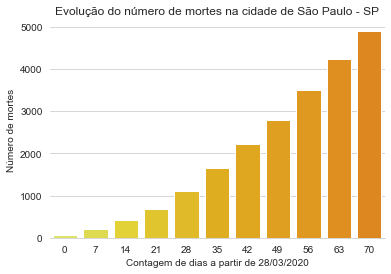

In [20]:
# Filtrando os dados para a cidade de São Paulo:
covid_sp = city_filter('São Paulo - SP')

# Avaliando o crescimento no número de mortes na capital paulista:
deaths_evolution(covid_sp, 'São Paulo - SP')

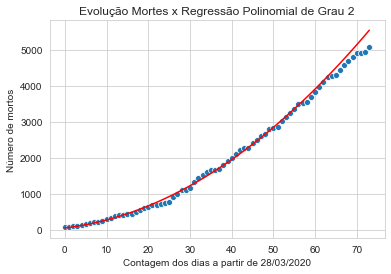

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 2 é de: 193.0.


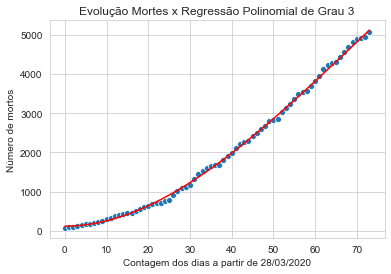

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 3 é de: 56.0.


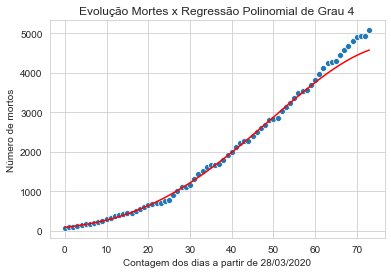

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 4 é de: 279.0.


In [21]:
# Criação e avaliação do modelo de regressão para a cidade de São Paulo:
sp_poly_regr_2, sp_model_2 = covid_poly_model(covid_sp, n_degree = 2, seed = 300)

sp_poly_regr_3, sp_model_3 = covid_poly_model(covid_sp, n_degree = 3, seed = 300)

sp_poly_regr_4, sp_model_4 = covid_poly_model(covid_sp, n_degree = 4, seed = 300)

<p>
    O crescimento do número de mortes na cidade de <b>São Paulo</b> não segue uma taxa linear. Este mesmo perfil é esperado nas demais cidades e, por isso, o modelo de regressão linear foi construído com uma transformação polinomial da variável preditora. </p>
<p>
    O <i>erro absoluto médio</i> apresentou grande diferença entre os graus testados. Observando a curva vermelha (que representa o modelo de regressão polinomial criado), aquela que melhor parece acompanhar a tendência de crescimento dos últimos dias é a curva relativa ao modelo de grau 3, sendo este assumido, portanto, como o grau que melhor respresenta o perfil da curva de crescimento estudada:
</p>

In [22]:
sp_poly_regr = sp_poly_regr_3
sp_model = sp_model_3

<p>
    Na seqüência, vamos repetir o procedimento para criação de um modelo preditivo para as cidades do <b>Rio de Janeiro</b>, <b>Belém</b> e <b>Porto Alegre</b>:
</p>

<h3 id = modelorj>Rio de Janeiro - RJ</h3>

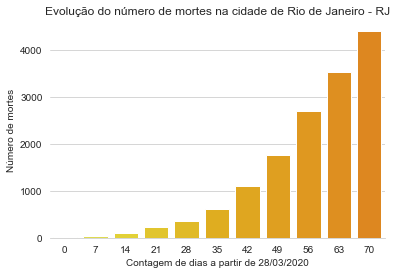

In [23]:
# Filtrando os dados para a cidade do Rio de Janeiro:
covid_rj = city_filter('Rio de Janeiro - RJ')

# Avaliando o crescimento no número de mortes na capital carioca:
deaths_evolution(covid_rj, 'Rio de Janeiro - RJ')

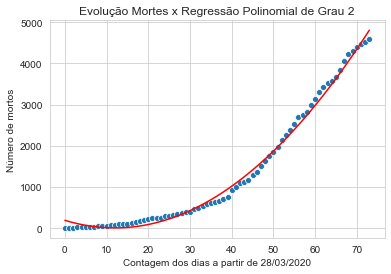

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 2 é de: 127.0.


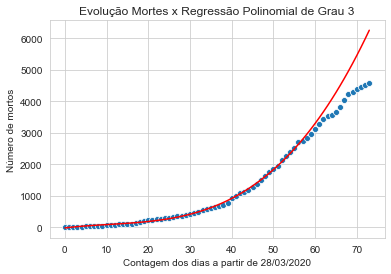

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 3 é de: 707.0.


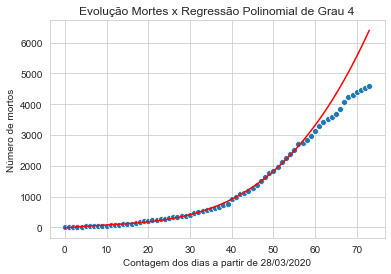

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 4 é de: 768.0.


In [24]:
# Criação e avaliação do modelo de regressão para a cidade do Rio de Janeiro:
rj_poly_regr_2, rj_model_2 = covid_poly_model(covid_rj, n_degree = 2, seed = 301)

rj_poly_regr_3, rj_model_3 = covid_poly_model(covid_rj, n_degree = 3, seed = 301)

rj_poly_regr_4, rj_model_4 = covid_poly_model(covid_rj, n_degree = 4, seed = 301)

<p>
    A regressão polinomial de grau 2 é a que apresenta o menor <i>mean absolut error</i> na previsão de mortos para os últimos dias e será, portanto, o modelo adotado para fazermos as previsões.
</p>

In [25]:
rj_poly_regr = rj_poly_regr_2
rj_model = rj_model_2

<h3 id = modelobl>Belém - PA</h3>

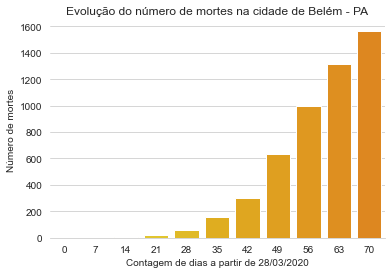

In [26]:
# Filtrando os dados para a cidade de Belém:
covid_bl = city_filter('Belém - PA')

# Avaliando o crescimento no número de mortes na capital paraense:
deaths_evolution(covid_bl, 'Belém - PA')

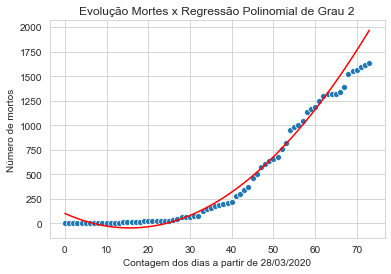

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 2 é de: 133.0.


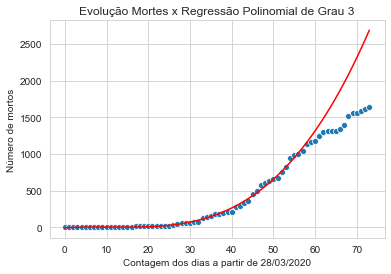

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 3 é de: 501.0.


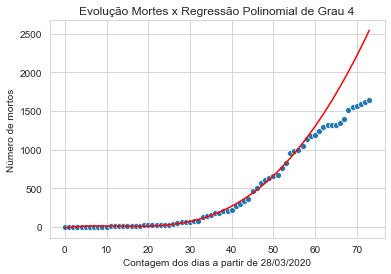

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 4 é de: 436.0.


In [27]:
# Criação e avaliação do modelo de regressão para a cidade de Belém:
bl_poly_regr_2, bl_model_2 = covid_poly_model(covid_bl, n_degree = 2, seed = 302)

bl_poly_regr_3, bl_model_3 = covid_poly_model(covid_bl, n_degree = 3, seed = 302)

bl_poly_regr_4, bl_model_4 = covid_poly_model(covid_bl, n_degree = 4, seed = 302)

<p>
    Novamente, pelo perfil das curvas apresentadas e pela avaliação de erros do modelo, podemos observar que, apesar do erro ser alto, o polinômio de grau 2 apresentou a melhor acurácia na previsão das mortes:
</p>

In [28]:
bl_poly_regr = bl_poly_regr_2
bl_model = bl_model_2

<h3 id = modelopa>Porto Alegre - RS</h3>

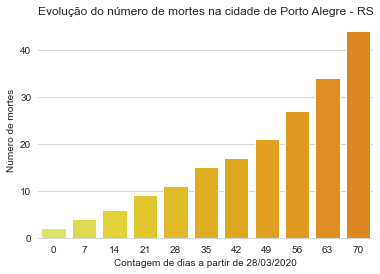

In [29]:
# Filtrando os dados para a cidade de Porto Alegre:
covid_pa = city_filter('Porto Alegre - RS')

# Avaliando o crescimento no número de mortes na capital gaúcha:
deaths_evolution(covid_pa, 'Porto Alegre - RS')

<p>
    Entre as capitais estudadas, <b>Porto Alegre</b> parece ter um crescimento de óbitos mais próximo a um perfil linear, ainda assim, usaremos uma aproximação polinomial para melhor representar a evolução dos casos de morte pela Covid-19 na cidade.
</p>

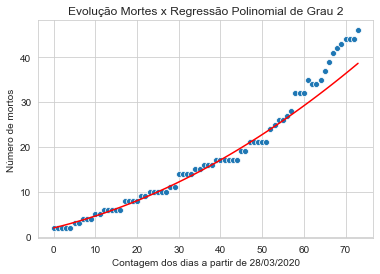

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 2 é de: 5.0.


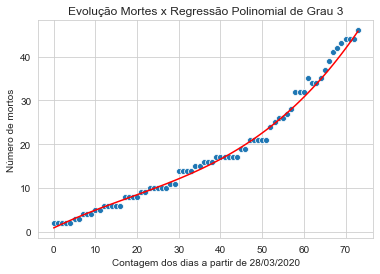

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 3 é de: 2.0.


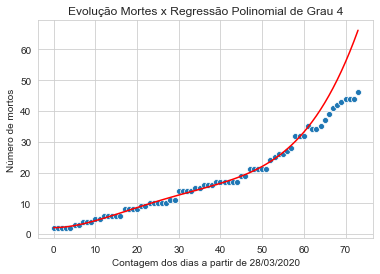

O erro médio absoluto da previsão do número de mortos para a regressão polinomial de grau 4 é de: 8.0.


In [30]:
# Criação e avaliação do modelo de regressão para a cidade de Porto Alegre:
pa_poly_regr_2, pa_model_2 = covid_poly_model(covid_pa, n_degree = 2, seed = 303)

pa_poly_regr_3, pa_model_3 = covid_poly_model(covid_pa, n_degree = 3, seed = 303)

pa_poly_regr_4, pa_model_4 = covid_poly_model(covid_pa, n_degree = 4, seed = 303)

<p>
    Entre os modelos testados, o de grau 3 é o que melhor acompanha a tendência de crescimento no número de mortos nos últimos dias, apresentando também o menor erro médio absoluto:
</p>

In [31]:
pa_poly_regr = pa_poly_regr_3
pa_model = pa_model_3

<p>
    Na seqüência, utilizaremos os modelos criados para prever o número total de mortes contabilizado em dias futuros. 
</p>
<p>
    <b>Importante</b>: cabe ressaltar mais uma vez que a única variável preditora deste estudo é a data de referência, sendo que outros fatores que interferem diretamente no número de mortes, tais como número de leitos disponíveis, perfil social da população, taxa de adesão ao distanciamento social, medidas tomadas pelo governo local, entre outros, não estão sendo diretamente considerados. Sendo assim, esta projeção de mortes não é sensível a possíveis alterações nestes fatores que definem a evolução da doença em cada uma das cidades que são objeto deste estudo.
</p>

<h2 id = prev>5- Previsão de mortes por Covid-19 nas cidades estudadas</h2>

In [32]:
# Carregando o arquivo com as datas futuras de referência e aplicando as transformações necessárias:
pred_df = pd.read_csv('covid_predict.csv', parse_dates = ['date'])
pred_df['day_count'] = (pred_df['date'] - min(covid_cap_br['date']))
pred_df['day_count']

0   75 days
1   76 days
Name: day_count, dtype: timedelta64[ns]

In [33]:
# Transformando a contagem de dias em números inteiros:
pred_df['day_count'] = pd.to_numeric(pred_df['day_count'].dt.days, downcast='integer')

In [34]:
# Criando uma função para facilitar a aplicação dos modelos criados anteriormente:
def make_prediction(model, poly_regr, cidade):
    """Utiliza os modelos de transformação polinomial e regressão linear criados anteriormente para fazer previsões.
    
    Args:
    model: modelo de regressão linear criado pela função covid_poly_model();
    poly_regr: modelo de transformação polinomial criado pela função covid_poly_model();
    cidade: string da cidade que é objeto da previsão.
    
    Returns:
    retorna duas strings com a previsão do número de mortos total até as duas datas contidas no objeto 'pred_df'.
    """
    Y_predicted = model.predict(poly_regr.fit_transform([[pred_df['day_count'][0]], [pred_df['day_count'][1]]]))
    
    print('Até ' + pred_df['date'][0].strftime('%d/%m/%Y') + ', na cidade de ' + cidade + ', a previsão é de ' +
      str(round(int(Y_predicted[0]))) + ' mortos por Covid-19.')
    
    print('Até ' + pred_df['date'][1].strftime('%d/%m/%Y') + ', na cidade de ' + cidade + ', a previsão é de ' +
      str(round(int(Y_predicted[1]))) + ' mortos por Covid-19.')

<h3 id = prevsp>Previsões para São Paulo - SP</h3>

In [35]:
# Fazendo as previsões para a cidade de São Paulo:
make_prediction(sp_model, sp_poly_regr, 'São Paulo - SP')

Até 11/06/2020, na cidade de São Paulo - SP, a previsão é de 5313 mortos por Covid-19.
Até 12/06/2020, na cidade de São Paulo - SP, a previsão é de 5413 mortos por Covid-19.


<h3 id = prevrj>Previsões para Rio de Janeiro - RJ</h3>

In [36]:
# Fazendo as previsões para a cidade do Rio de Janeiro:
make_prediction(rj_model, rj_poly_regr, 'Rio de Janeiro - RJ')

Até 11/06/2020, na cidade de Rio de Janeiro - RJ, a previsão é de 5122 mortos por Covid-19.
Até 12/06/2020, na cidade de Rio de Janeiro - RJ, a previsão é de 5286 mortos por Covid-19.


<h3 id = prevbl>Previsões para Belém - PA</h3>

In [37]:
# Fazendo as previsões para a cidade de Belém:
make_prediction(bl_model, bl_poly_regr, 'Belém - PA')

Até 11/06/2020, na cidade de Belém - PA, a previsão é de 2110 mortos por Covid-19.
Até 12/06/2020, na cidade de Belém - PA, a previsão é de 2183 mortos por Covid-19.


<h3 id = prevpa>Previsões para Porto Alegre - RS</h3>

In [38]:
# Fazendo as previsões para a cidade de Porto Alegre:
make_prediction(pa_model, pa_poly_regr, 'Porto Alegre - RS')

Até 11/06/2020, na cidade de Porto Alegre - RS, a previsão é de 48 mortos por Covid-19.
Até 12/06/2020, na cidade de Porto Alegre - RS, a previsão é de 50 mortos por Covid-19.


<h2 id = conclusao>6- Conclusão</h2>

<p>
    As cidades estudadas apresentam perfis diferentes de evolução do número de mortes, sendo que a grande variação diária de notificações não permite prever com maior precisão a tendência dos próximos dias. No entanto, como panorama geral, é possível observar que existe uma tendência crescente de mortes, mesmo em cidades com situação mais confortável. Não é possível afirmar se o país de um modo geral já chegou ao pico da pandemia, no entanto, pode-se afirmar que o país não entrou na fase de redução de casos confirmados ou de mortes.
</p>
<p>
    Desta forma, nos resta apenas continuar seguindo as recomendações estabelecidas pelos órgãos técnicos responsáveis que, em sua grande maioria, recomendam o distanciamento social, a higienização constante das mãos, uso de máscaras de proteção, entre outros.
</p>

### Fim.